## Cats vs Dogs Audio Classification using DL

#### Imports

In [68]:
import os
from pydub import AudioSegment
from scipy.io import wavfile
from tempfile import mktemp
from IPython.display import Audio
import matplotlib.pyplot as plt

import librosa
import librosa.display

import keras
import numpy as np
import tensorflow as tf
from matplotlib.image import imread
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.preprocessing import image
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from keras.applications import MobileNetV2

#### Data Preparation

In [20]:
def create_spectogram(audio_file_name,source_path,save_path): 
  x, sr = librosa.load(source_path+audio_file_name)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(14, 5))
  librosa.display.specshow(Xdb, sr=sr, y_axis='hz')
  plt.ylabel('')
  plt.axis('off')
  file_name = audio_file_name.replace('.wav','')
  plt.savefig(save_path+file_name+'.jpg', bbox_inches='tight', pad_inches=0)
  plt.close()

In [21]:
CAT_TRAIN = '../Dataset/cats_dogs/train/cat/' 
for sound in os.listdir(CAT_TRAIN): 
  create_spectogram(sound,CAT_TRAIN,'../Dataset/images/train/cat/')

In [22]:
CAT_TEST = '../Dataset/cats_dogs/test/cats/' 
for sound in os.listdir(CAT_TEST): 
  create_spectogram(sound,CAT_TEST,'../Dataset/images/test/cat/')

In [23]:
DOG_TRAIN = '../Dataset/cats_dogs/train/dog/' 
for sound in os.listdir(DOG_TRAIN): 
  create_spectogram(sound,DOG_TRAIN,'../Dataset/images/train/dog/')

In [24]:
DOG_TEST = '../Dataset/cats_dogs/test/dogs/' 
for sound in os.listdir(DOG_TEST): 
  create_spectogram(sound,DOG_TEST,'../Dataset/images/test/dog/')

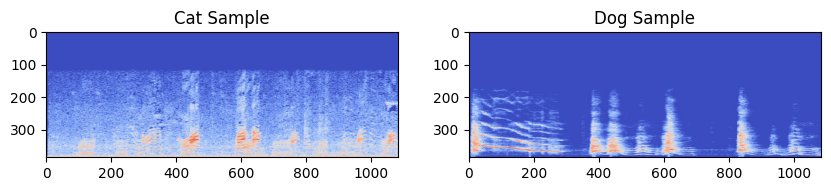

In [25]:
# Take a peek at image data 
sample_cat = '../Dataset/images/test/cat/cat_28.jpg' 
sample_cat = plt.imread(sample_cat)
sample_dog = '../Dataset/images/train/dog/dog_barking_20.jpg'
sample_dog = plt.imread(sample_dog)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,2)) 
ax1.imshow(sample_cat)
ax1.set_title('Cat Sample')
ax2.imshow(sample_dog)
ax2.set_title('Dog Sample')
plt.show()

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
train_data = os.path.join('../Dataset/images/train/')
val_data = os.path.join('../Dataset/images/test/')

In [28]:
train_generator = train_datagen.flow_from_directory(train_data,
                                                    target_size=(250, 250),
                                                    batch_size=30,
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(val_data,
                                                        target_size=(250, 250),
                                                        batch_size=30,
                                                        color_mode='rgb',
                                                        shuffle=True,
                                                        class_mode='binary')

Found 210 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [43]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

#### Approach 1: CNN

In [29]:
model = Sequential([Conv2D(40, (5,5), activation='relu', input_shape=(250, 250, 3)),
                    MaxPooling2D(3, 3),
                    
                    Conv2D(80, (5,5), activation='relu'),
                    MaxPooling2D(3, 3),
                    
                    Conv2D(160, (5,5), activation='relu'),
                    MaxPooling2D(3, 3),
                    Flatten(),
                    
                    Dense(400, activation='tanh', kernel_initializer='normal'),
                    Dropout(0.3), # Dropout Layer
                    Dense(200, activation='tanh', kernel_initializer='normal'), # Hidden Layer
                    Dropout(0.3), # Dropout Layer
                    Dense(100, activation='tanh', kernel_initializer='normal'), # Hidden Layer
                    Dense(1, activation='sigmoid')
                    ])

In [37]:
opt  = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              metrics=['accuracy'],
              loss='binary_crossentropy')

In [40]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') >= 0.9:
            self.model.stop_training = True

In [42]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    batch_size=64)

Epoch 1/20
7/7 [==============================] - 3s 358ms/step - loss: 0.1772 - accuracy: 0.9381 - val_loss: 0.2485 - val_accuracy: 0.8806
Epoch 2/20
7/7 [==============================] - 2s 327ms/step - loss: 0.1725 - accuracy: 0.9381 - val_loss: 0.2525 - val_accuracy: 0.9254
Epoch 3/20
7/7 [==============================] - 2s 333ms/step - loss: 0.1591 - accuracy: 0.9381 - val_loss: 0.2455 - val_accuracy: 0.9104
Epoch 4/20
7/7 [==============================] - 2s 326ms/step - loss: 0.1538 - accuracy: 0.9476 - val_loss: 0.2370 - val_accuracy: 0.9254
Epoch 5/20
7/7 [==============================] - 2s 326ms/step - loss: 0.1428 - accuracy: 0.9524 - val_loss: 0.2291 - val_accuracy: 0.9254
Epoch 6/20
7/7 [==============================] - 2s 330ms/step - loss: 0.1140 - accuracy: 0.9619 - val_loss: 0.2186 - val_accuracy: 0.9254
Epoch 7/20
7/7 [==============================] - 2s 325ms/step - loss: 0.1167 - accuracy: 0.9714 - val_loss: 0.2376 - val_accuracy: 0.9254
Epoch 8/20
7/7 [====

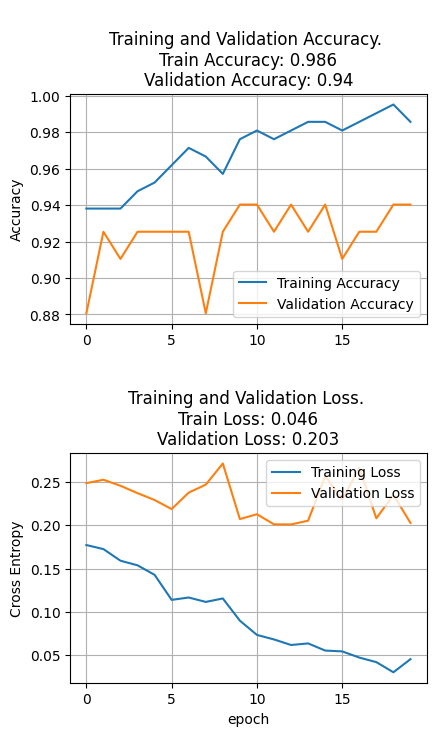

In [44]:
plot_history(history)

In [51]:
# predictions
from keras.preprocessing import image
def make_prediction(image_path): 
    img = image.load_img(image_path, target_size=(250,250,3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) 
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10) 
    if classes[0]>0.5:
        print("Its a dog")
    else:
        print("Its a cat")
    return

In [52]:
make_prediction('../Dataset/images/test/cat/cat_67.jpg')

1/1 [==============================] - 0s 15ms/step
Its a cat


In [54]:
make_prediction('../Dataset/images/test/dog/dog_barking_12.jpg')

1/1 [==============================] - 0s 24ms/step
Its a dog


#### Approach 2: VGG16

In [56]:
# Load the pre-trained VGG16 model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
base_model.trainable = False
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  
x = tf.keras.layers.Dense(1024, activation='relu')(x)   
x = tf.keras.layers.Dropout(0.6)(x) 
predictions = Dense(1, activation='sigmoid')(x)  

In [58]:
# Create the final model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

In [59]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [60]:
vgg16_model.compile(optimizer = opt,
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [61]:
history = vgg16_model.fit(train_generator,
                       epochs=20,
                       validation_data=validation_generator,
                       verbose=1)

Epoch 1/20
7/7 [==============================] - 6s 691ms/step - loss: 1.6973 - accuracy: 0.5952 - val_loss: 2.4471 - val_accuracy: 0.4328
Epoch 2/20
7/7 [==============================] - 4s 623ms/step - loss: 1.2722 - accuracy: 0.7000 - val_loss: 1.8366 - val_accuracy: 0.7612
Epoch 3/20
7/7 [==============================] - 4s 626ms/step - loss: 1.2379 - accuracy: 0.7714 - val_loss: 0.9388 - val_accuracy: 0.7463
Epoch 4/20
7/7 [==============================] - 4s 626ms/step - loss: 0.9274 - accuracy: 0.7571 - val_loss: 0.7790 - val_accuracy: 0.8209
Epoch 5/20
7/7 [==============================] - 5s 664ms/step - loss: 0.6069 - accuracy: 0.8524 - val_loss: 0.9720 - val_accuracy: 0.8657
Epoch 6/20
7/7 [==============================] - 4s 626ms/step - loss: 0.4873 - accuracy: 0.8714 - val_loss: 0.7071 - val_accuracy: 0.8507
Epoch 7/20
7/7 [==============================] - 5s 645ms/step - loss: 0.3645 - accuracy: 0.8905 - val_loss: 0.6658 - val_accuracy: 0.8209
Epoch 8/20
7/7 [====

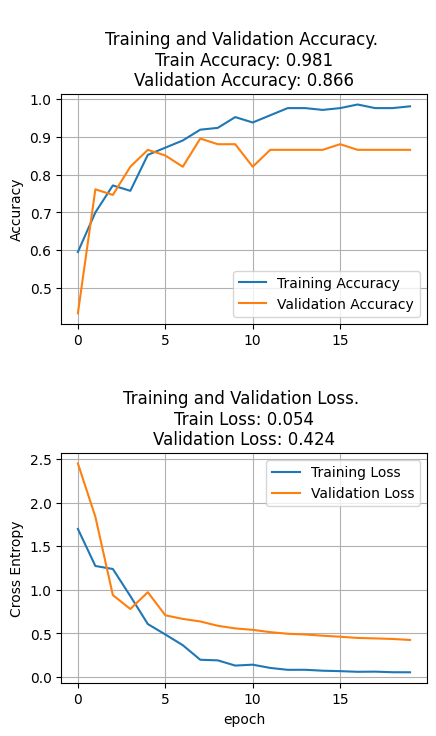

In [62]:
plot_history(history)

#### Approach 3: ResNet50

In [63]:
# Load the pre-trained ResNet50 model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
base_model.trainable = False
last_output = base_model.output 
x = tf.keras.layers.Flatten()(last_output)  
x = tf.keras.layers.Dense(1024, activation='relu')(x)   
x = tf.keras.layers.Dropout(0.6)(x) 
predictions = Dense(1, activation='sigmoid')(x) 

In [64]:
# create the final model
resnet50_model = Model(inputs=base_model.input, outputs=predictions)
resnet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 125, 125, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 125, 125, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [65]:
resnet50_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [66]:
# Train the model
resnet50_history = model.fit(train_generator,
                       epochs=20,
                       validation_data=validation_generator,
                       verbose=1)

Epoch 1/20
7/7 [==============================] - 3s 362ms/step - loss: 0.0244 - accuracy: 0.9952 - val_loss: 0.2506 - val_accuracy: 0.9403
Epoch 2/20
7/7 [==============================] - 2s 332ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.2175 - val_accuracy: 0.9104
Epoch 3/20
7/7 [==============================] - 2s 327ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.2532 - val_accuracy: 0.9403
Epoch 4/20
7/7 [==============================] - 2s 331ms/step - loss: 0.0200 - accuracy: 0.9952 - val_loss: 0.2181 - val_accuracy: 0.9403
Epoch 5/20
7/7 [==============================] - 2s 330ms/step - loss: 0.0198 - accuracy: 0.9952 - val_loss: 0.2443 - val_accuracy: 0.9403
Epoch 6/20
7/7 [==============================] - 2s 332ms/step - loss: 0.0173 - accuracy: 0.9952 - val_loss: 0.2412 - val_accuracy: 0.9254
Epoch 7/20
7/7 [==============================] - 2s 328ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.2127 - val_accuracy: 0.9254
Epoch 8/20
7/7 [====

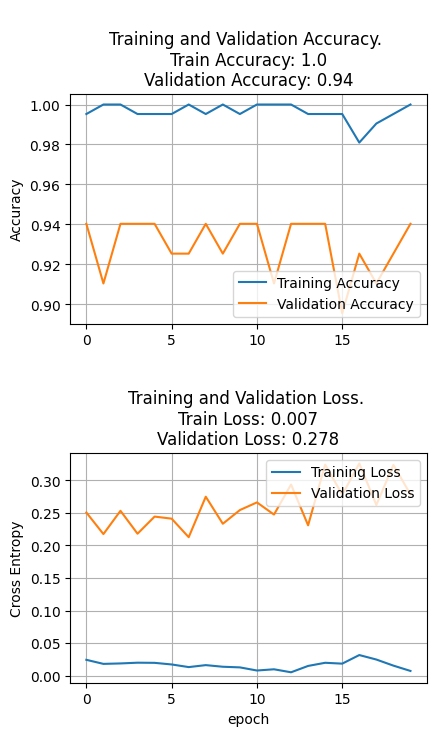

In [67]:
plot_history(resnet50_history)

#### Approach 4: MobileNetV2

In [69]:
# load the pre-trained mobilenet model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
base_model.trainable = False

In [70]:
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x) 

In [71]:
# Create the final model
mobilenetv2_model = Model(inputs=base_model.input, outputs=predictions)

In [72]:
mobilenetv2_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 125, 125, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 125, 125, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 125, 125, 32)         0         ['bn_Conv1[0][0]']      

In [73]:
mobilenetv2_model.compile(optimizer = opt,
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [74]:
# Train the model
mobilenetv2_history = mobilenetv2_model.fit(train_generator,
                       epochs=20,
                       validation_data=validation_generator,
                       verbose=1)

Epoch 1/20
7/7 [==============================] - 6s 417ms/step - loss: 8.7805 - accuracy: 0.7238 - val_loss: 11.2571 - val_accuracy: 0.8060
Epoch 2/20
7/7 [==============================] - 2s 305ms/step - loss: 6.0238 - accuracy: 0.8714 - val_loss: 5.0481 - val_accuracy: 0.8955
Epoch 3/20
7/7 [==============================] - 2s 307ms/step - loss: 3.4963 - accuracy: 0.9286 - val_loss: 6.9736 - val_accuracy: 0.9104
Epoch 4/20
7/7 [==============================] - 2s 297ms/step - loss: 2.0599 - accuracy: 0.9429 - val_loss: 6.4708 - val_accuracy: 0.9104
Epoch 5/20
7/7 [==============================] - 2s 301ms/step - loss: 1.1590 - accuracy: 0.9571 - val_loss: 4.8715 - val_accuracy: 0.9104
Epoch 6/20
7/7 [==============================] - 2s 300ms/step - loss: 0.9427 - accuracy: 0.9619 - val_loss: 6.6349 - val_accuracy: 0.9104
Epoch 7/20
7/7 [==============================] - 2s 297ms/step - loss: 1.0030 - accuracy: 0.9810 - val_loss: 7.4046 - val_accuracy: 0.8955
Epoch 8/20
7/7 [===

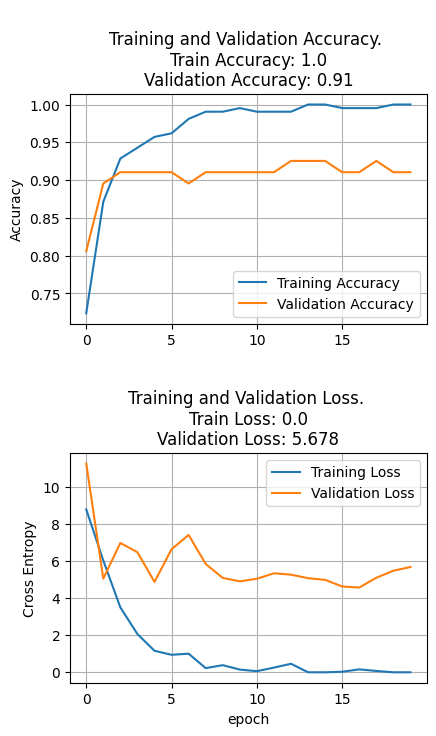

In [75]:
plot_history(mobilenetv2_history)